# Test NoveltyDatamodule sanity

In [2]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("..")

from src.data import NoveltyDetectionDatamodule
import torchvision
import torch
from lightning_toolbox.data import  PairedDataTransform
import dypy as dy
dy.register_context(torchvision)
# dy.register_context(torch) 


dm = NoveltyDetectionDatamodule(
    dataset="torchvision.datasets.MNIST",
    val_size=0.05,
    dataset_args=dict(
        root="data",
        train=True,
        download=True,
    ),
    transforms=[
        PairedDataTransform(
            input_transforms=[
                "torchvision.transforms.ToTensor",
             "torchvision.transforms.Normalize((0.1307,), (0.3081,))", 
            ],
        ),
    ],
    normal_targets=[8],
    batch_size=128,
    num_workers=0,
    pin_memory=True,
)

dm.setup("fit")

c:\Users\altaf\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:00<00:00, 30603229.38it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28883093.42it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 13521174.38it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4727178.35it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



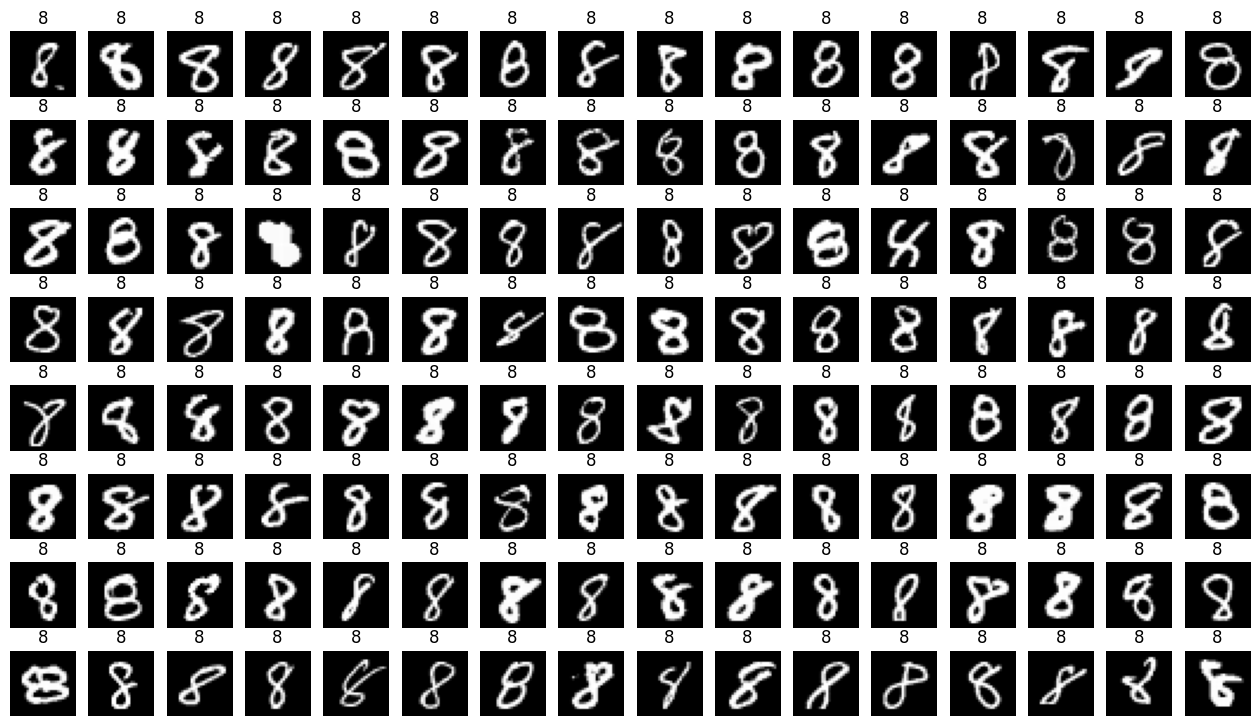

In [5]:
# show the first batch from the training set and their labels
from matplotlib import pyplot as plt
import numpy as np

batch = next(iter(dm.train_dataloader()))
images, labels = batch
images = images.numpy()
labels = labels.numpy()

batch_size = images.shape[0]
n_cols = 16
n_rows = batch_size // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows+1))
for i in range(n_rows):
    for j in range(n_cols):
        axes[i, j].imshow(images[i * n_cols + j].squeeze(), cmap='gray')
        axes[i, j].set_title(labels[i * n_cols + j])
        axes[i, j].axis('off')
plt.show()

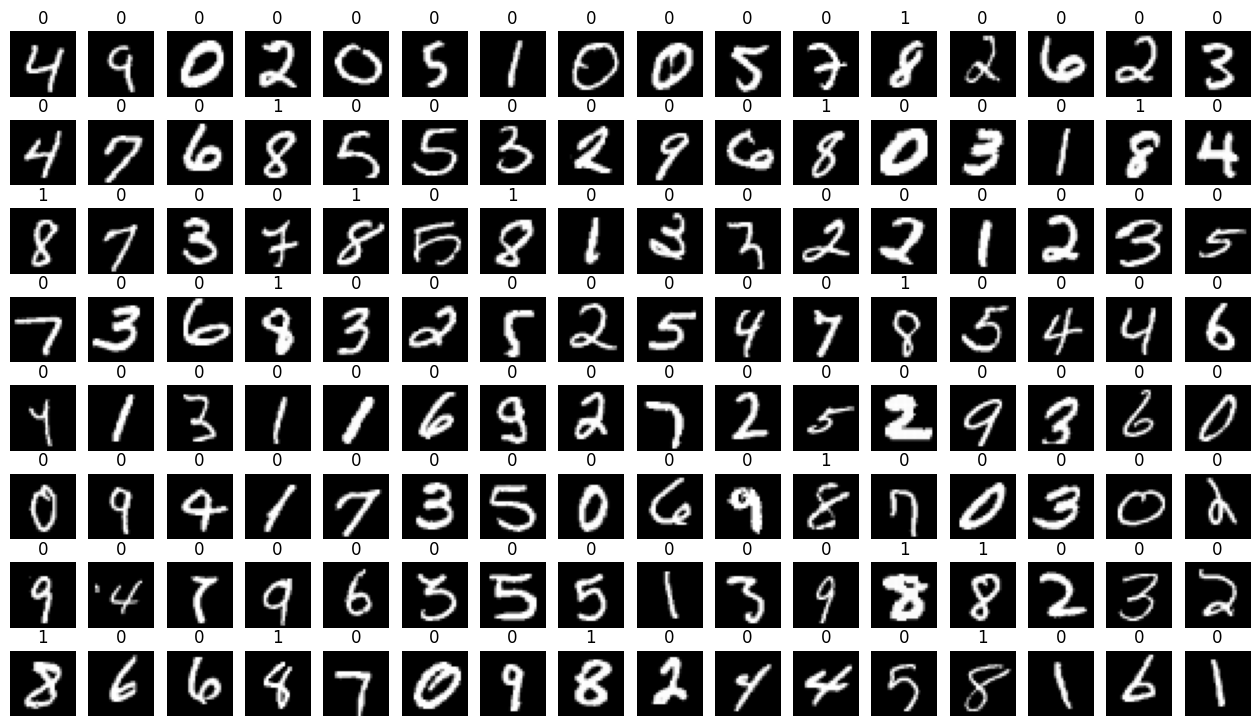

In [6]:
# show the first batch from the validation set and their labels
batch = next(iter(dm.val_dataloader()))
images, labels = batch
images = images.numpy()
labels = labels.numpy()

batch_size = images.shape[0]
n_cols = 16
n_rows = batch_size // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows+1))
for i in range(n_rows):
    for j in range(n_cols):
        axes[i, j].imshow(images[i * n_cols + j].squeeze(), cmap='gray')
        axes[i, j].set_title(labels[i * n_cols + j])
        axes[i, j].axis('off')
plt.show()


# Sanity Check MLPAutoEncoder

In [7]:
from src.models import MLPAutoEncoder
model = MLPAutoEncoder(
    input_shape=(1, 28, 28),
    encoder_width=128,
    decoder_width=128,
    latent_dim=32,
    encoder_depth=2,
    decoder_depth=4,
    args=dict(
        dropout=0.2,
        # normalization=None,
    )
)
assert model(torch.randn(128, 1, 28, 28)).shape == (128, 1, 28, 28)
assert model.encoder(torch.randn(128, 1, 28, 28)).shape == (128, 32)

/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Sanity Check ConvAutoencoder

In [8]:
from src.models.cnn import LazyConvBlock 

block = LazyConvBlock(16)
assert block(torch.randn(128, 1, 28, 28)).shape == (128, 16, 14, 14)

block = LazyConvBlock(16, stride=1)
assert block(torch.randn(128, 1, 28, 28)).shape == (128, 16, 28, 28)

c:\Users\altaf\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Sanity Check Training

In [10]:
import lightning_toolbox
import lightning
from src.callbacks import NoveltyAUROCCallback
tm = lightning_toolbox.TrainingModule(
    model=model,
    lr = 1e-3,
    objective_args=dict(
        mse="lambda batch, training_module: torch.nn.functional.mse_loss(training_module(batch[0]), batch[0], reduction='none').mean(dim=(1, 2, 3))",
    ),
    optimizer="torch.optim.Adam",
)

trainer = lightning.Trainer(
    callbacks=[
        NoveltyAUROCCallback()
    ]
)
trainer.fit(tm, dm)

ValueError: Expected a parent

In [ ]:
[]